# Preprocessing Notebook

## In this notebook we will use FeatureTools to generate more features to help us establish relationships with our main dataframe.  We will then add our baseline model in a Logistic Regression here.

### Let's get started again imported the tools we will need for these tasks.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split


### Next let's read in our main dataframe and take a quick look.

In [2]:
df_mod = pd.read_csv(f'/Users/ryanm/Desktop/df-mod.csv')
print(df_mod.shape)
df_mod.head(5)

(3214874, 14)


,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,product_name_code,aisle_code,department_code
0,1,1,2539329,3,9,12.0,26405,5,0,54,17,31683,99,11
1,1,2,2398795,4,8,16.0,26088,6,1,23,19,980,103,20
2,1,3,473747,4,13,22.0,30450,5,1,88,13,7124,124,16
3,1,4,2254736,5,8,30.0,26405,5,1,54,17,31683,99,11
4,1,5,431534,5,16,29.0,41787,8,1,24,4,2419,50,19


### Looks good, now let's use FeatureTools to generate more useful features to contribute to our baseline model.

In [ ]:
# FeatureTools work goes here!!!

### Excellent, lots of neat features to add to our data for the forthcoming model.  Let's establish our X,y values and run our Logistic Regression model and see what our baseline efficiency is.

In [3]:
X = df_mod.drop('reordered', axis = 1)
y = df_mod['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test, lr_y_pred)
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_cls_report = classification_report(y_test, lr_y_pred)

print("Metrics for Logistic Regression Model")
print("Accuracy: ", lr_acc)
print("Confusion Matrix: ", lr_conf_matrix)
print(lr_cls_report)

Metrics for Logistic Regression Model
Accuracy:  0.879387223453478
Confusion Matrix:  [[     0  77551]
 [     0 565424]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     77551
           1       0.88      1.00      0.94    565424

    accuracy                           0.88    642975
   macro avg       0.44      0.50      0.47    642975
weighted avg       0.77      0.88      0.82    642975



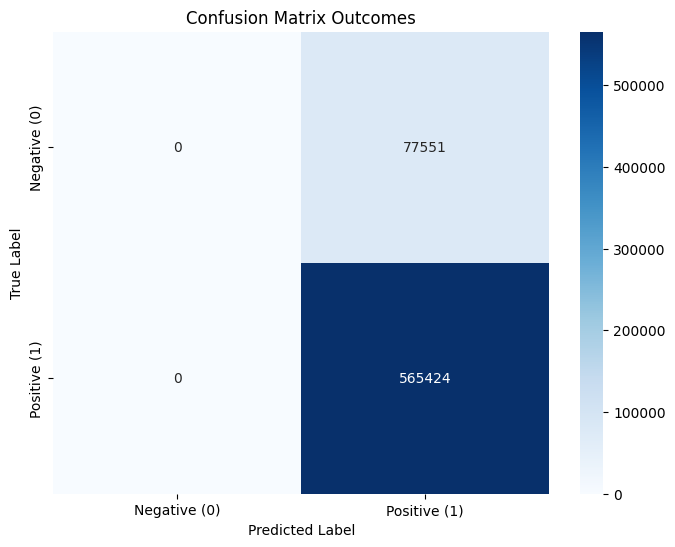

In [5]:
plt.figure(figsize = (8,6))
sns.heatmap(lr_conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Negative (0)', 'Positive (1)'], yticklabels = ['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Outcomes')
plt.show()

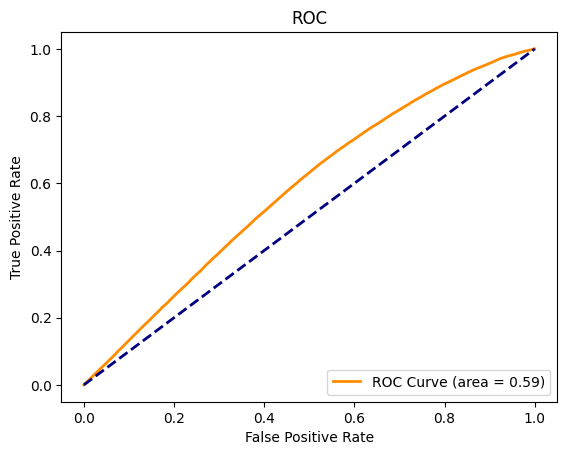

In [6]:
probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
lr_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC Curve (area = %0.2f)' % lr_roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc = 'lower right')
plt.show()

### Some observations to be made from our first model, the model didn't read the minority (0 value) very well at all.  We need to resample and rebalance the weights, then use GridSearchCV and run the model again to get a better outcome.